In [1]:
%load_ext autoreload
%autoreload 2

### Static Mnist Video - Heatmap Prediction

Heatmap is predicted in a video with static unmoving frames where an mnist digit is placed randomly in a larger canvas.

In [2]:
from generate import *

/share/apps/python3/3.6.3/intel/lib/python3.6/site-packages/h5py-2.7.1-py3.6-linux-x86_64.egg/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz


In [3]:
time_steps=6
num_units=128
imsize=64
infsize=16

In [4]:
import tensorflow as tf
sess = tf.Session()

In [5]:
inputs = tf.placeholder(tf.float32, [None, time_steps, imsize, imsize])
labels = tf.placeholder(tf.float32, [None, infsize, infsize, 1])

input_steps = tf.unstack(inputs, time_steps, 1)

conv_results = []
for frame in input_steps:
    shaped_frame = tf.reshape(frame, [-1, imsize, imsize, 1])
    
    # conv weights are shared across time steps t-6 .... t
    with tf.variable_scope('SingularConv', reuse=tf.AUTO_REUSE):
        # 64
        carry = tf.layers.conv2d(shaped_frame, 32, 3, (1, 1), padding='same', activation=tf.nn.relu)
        carry = tf.layers.conv2d(carry, 64, 3, (2, 2), padding='same', activation=tf.nn.relu)

        # 32
        carry = tf.layers.conv2d(carry, 128, 3, (1, 1), padding='same', activation=tf.nn.relu)
        carry = tf.layers.conv2d(carry, 128, 3, (2, 2), padding='same', activation=tf.nn.relu)
        
        # 16
#         carry = tf.layers.conv2d(carry, 256, 3, (1, 1), padding='same', activation=tf.nn.relu)
#         carry = tf.layers.conv2d(carry, 256, 3, (1, 1), padding='same', activation=tf.nn.relu)
#         carry = tf.layers.conv2d(carry, 256, 3, (2, 2), padding='same', activation=tf.nn.relu)
        
#         carry = tf.layers.conv2d(carry, 256, 3, (2, 2), padding='same', activation=tf.nn.relu)
        
        conv_results.append(carry)

In [6]:
print(len(conv_results))
print(conv_results[0].shape)
flattened_steps = [tf.reshape(result, [-1, 16**2 * 128]) for result in conv_results]
print(flattened_steps[0].shape)
# assert False

6
(?, 16, 16, 128)
(?, 32768)


In [7]:
from tensorflow.contrib import rnn

#defining the network
lstm_cell=rnn.BasicLSTMCell(512)
lstm_out, _ = rnn.static_rnn(lstm_cell, flattened_steps,dtype=tf.float32)

In [8]:
last_out = lstm_out[-1]
print(last_out.shape)

carry = tf.layers.dense(last_out, 16**2 * 128)
carry = tf.reshape(carry, [-1, 16, 16, 128])
carry = tf.layers.conv2d(carry, 128, 3, (1, 1), padding='same', activation=tf.nn.relu)
carry = tf.layers.conv2d(carry, 128, 3, (1, 1), padding='same', activation=tf.nn.relu)
carry = tf.layers.conv2d(carry, 256, 3, (1, 1), padding='same', activation=tf.nn.relu)
carry = tf.layers.conv2d(carry, 1, 3, (1, 1), padding='same')

print(carry.shape)

guesses = carry


heat_loss = tf.nn.l2_loss(guesses - labels)
heat_opt = tf.train.AdamOptimizer(learning_rate=0.001).minimize(heat_loss)

(?, 512)
(?, 16, 16, 1)


In [9]:
# correct_prediction = tf.equal(tf.argmax(guesses,1), tf.argmax(labels,1))
# accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [10]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt

MAX_ITER = 800
BATCH_SIZE=16

init=tf.global_variables_initializer()

sess.run(init)

def prep_data(batch_x, batch_y, bsize=BATCH_SIZE):
    batch_x = batch_x.reshape((bsize,28,28))
    animated = [animate(place(digit, frame_size=64), steps=0, size=64) for digit in batch_x]
    first_frames = [data[0][0] for data in animated]
    first_coords = [data[1][0] for data in animated]
    
    static_video = np.stack([first_frames]*time_steps, axis=1)
    first_heats = [matching_heatmap([coord], framesize=64)[0] for coord in first_coords]
    sized_heats = np.array([cv2.resize(heat, (0,0), fx=0.25, fy=0.25) for heat in first_heats])
    sized_heats = sized_heats.reshape((bsize, 16, 16, 1))
    return static_video, sized_heats
    

epoch = 1
while epoch < MAX_ITER:
    batch_x, batch_y = mnist.train.next_batch(batch_size=BATCH_SIZE)

    static_video, sized_heats = prep_data(batch_x, batch_y)
#     plt.figure()
#     plt.subplot(1, 2, 1)
#     plt.imshow(static_video[0][0])
#     plt.subplot(1, 2, 2)
#     plt.imshow(sized_heats[0])
#     plt.show()
#     break

    sess.run(heat_opt, feed_dict={inputs: static_video, labels:sized_heats })
#     break

    if epoch %10==0:
        train_loss = sess.run(heat_loss,feed_dict={inputs:static_video,labels:sized_heats})
        
        
        test_data = mnist.test.images[:128].reshape((-1, 28, 28))
        test_label = mnist.test.labels[:128]
        static_video, sized_heats = prep_data(test_data, test_label, bsize=128)
        test_loss = sess.run(heat_loss, feed_dict={inputs: static_video, labels: sized_heats})


        sys.stdout.write('[%d/%d] L = %.2f / %.2f\r' % (epoch, MAX_ITER, train_loss / BATCH_SIZE, test_loss / 128))
        sys.stdout.flush()

    epoch = epoch + 1
    
print()

# # calculating test accuracy


[790/800] L = 0.02 / 0.03


In [12]:
test_data = mnist.test.images[:1].reshape((-1, 28, 28))
test_label = mnist.test.labels[:1]
static_video, sized_heats = prep_data(test_data, test_label, bsize=1)
heat_guess = sess.run(guesses, feed_dict={inputs: static_video, labels: sized_heats})

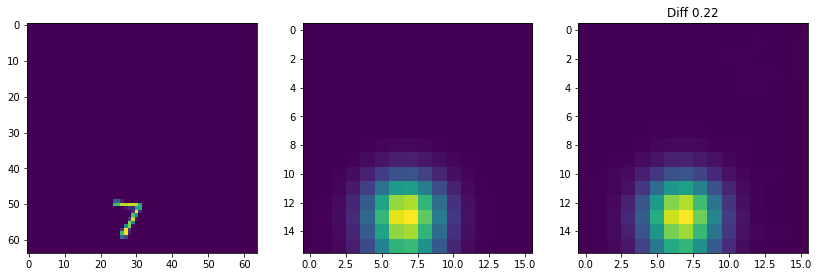

In [17]:
import numpy.linalg as la

plt.figure(figsize=(14, 7))
plt.subplot(1, 3, 1)
plt.imshow(static_video[0][0])
plt.subplot(1, 3, 2)
plt.imshow(sized_heats[0].reshape((16, 16)))
plt.subplot(1, 3, 3)
plt.gca().set_title('Diff %.2f' % la.norm(heat_guess[0] - sized_heats[0]))
plt.imshow(heat_guess[0].reshape((16, 16)))
plt.show()